# Carregar as bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn


In [2]:
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter


# Carregar os dados e fazer avaliação preliminar

- Quais colunas são úteis?
- Quais dados estão ausentes? *Cuidado com o dropnan

In [3]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Ambas as colunas de idade e cabine estão com diversas entradas faltando, 177 e 687 respectivamente, onde a primeira é interessante para ser utilizada no modelo. Porém, além de ter vários dados ausentes, a coluna do número da cabine e a coluna do número do ticket são descartáveis para a análise, uma vez que são irrelevantes para questões de sobrevivência. (**Seria possível avaliar o peso de tickets e da posição das cabines, mas não é o meu intuito no momento**)

In [5]:
#Remover colunas primeiro;
df = df.drop(['Ticket','Cabin', 'PassengerId'], axis=1)
df_test = df_test.drop(['Ticket','Cabin'], axis=1)

# Análise exploratória dos dados

## Análise de features

Analisar as features categóricas e numéricas para propor e realizar tratamentos para melhor acomodar os dados para os modelos. Algumas coisas já foram avaliadas anteriormente na pré-visualização, então não serão retomadas aqui.

### Features categóricas
- Sex (female, male)
- Embarked (S, Q, C)
- Pclass (1, 2, 3)

#### Sex

In [6]:
df['Sex'].value_counts(dropna = False)

male      577
female    314
Name: Sex, dtype: int64

In [7]:
df[['Sex', 'Survived']].groupby('Sex', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Como já é esperado, a taxa de sobrevivência de mulheres é bem maior que a de homens. O clássico filme já diz "Primeiro as mulheres e crianças". 

Já que é uma variável binária, vou converter de male e female para 0 e 1.

In [8]:
def conversão_sexo(x):
    if x == 'male':
        return 1
    else:
        return 0

In [9]:
df['Sex'] = df['Sex'].map(conversão_sexo)
df_test['Sex'] = df_test['Sex'].map(conversão_sexo)

#### PClass (Classe da cabine)

In [10]:
df['Pclass'].value_counts(dropna = False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

[Text(0.5, 1.0, 'Sobrevivência por classe'), Text(0, 0.5, 'Sobrevivência')]

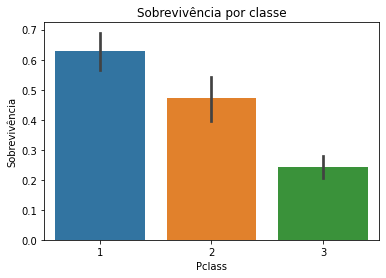

In [11]:
ax1 = sns.barplot(x = 'Pclass', y ='Survived', data = df)
ax1.set(title = "Sobrevivência por classe", ylabel = 'Sobrevivência')

A maioria de sobreviventes pertence á primeira classe, sendo seguida pela segunda e tendo como menor número de sobreviventes os membros da terceira classe. É interessante aqui abordar a relação sexo e classe com a sobrevivência.

[Text(0.5, 1.0, 'Sobrevivência por classe e sexo'),
 Text(0, 0.5, 'Sobrevivência')]

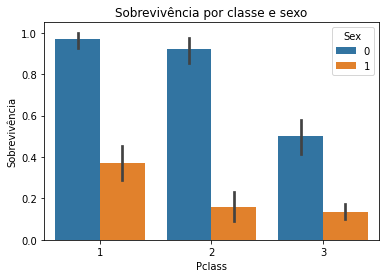

In [12]:
ax2 = sns.barplot(x = 'Pclass', y ='Survived', hue = 'Sex', data = df)
ax2.set(title = "Sobrevivência por classe e sexo", ylabel = 'Sobrevivência')

A probabilidade da sobrevivência da terceira classe é menor que a metade da primeira classe tanto para mulheres quanto para homens. Como já é numérica (1, 2, 3) não tem necessidade de alterar essa variável.

#### Embarked

In [13]:
df['Embarked'].value_counts(dropna = False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

Como já tinha sido observado antes, a variável Embarked tem duas entradas Nan. Uma opção aqui é completar estas entradas com a moda da coluna Embarked.

In [14]:
print(df['Embarked'].dropna().mode())

0    S
Name: Embarked, dtype: object


In [15]:
df['Embarked'].fillna('S', inplace = True)
df['Embarked'].value_counts(dropna = False)

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Como feito com sexo, temos que converter o ponto de embarque em uma variável codificada. Para isso, vou usar o get_dummies() do pandas

In [16]:
df = pd.get_dummies(df, columns = ['Embarked'], prefix = 'Em')
df_test = pd.get_dummies(df_test, columns = ['Embarked'], prefix = 'Em')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,1,0,0
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,0,0,1
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,0,0,1


### Variáveis numéricas

- SibSp 
- Parch
- Age
- Fare

#### Tratamento de outlier e verificar as correlações

In [17]:
def detect_outliers(df, n, features):
    """"
    This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds
    third quartile plus the outlier step. The outlier step is defined as 1.5 times the interquartile range. Once the 
    outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next
    feature and the process repeats until the very last feature is completed. Finally, using the list with outlier 
    indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times.    
    """
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(df, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [18]:
print("Antes: {} rows".format(len(df)))
df = df.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("Depois: {} rows".format(len(df)))

Antes: 891 rows
Depois: 881 rows


<AxesSubplot:>

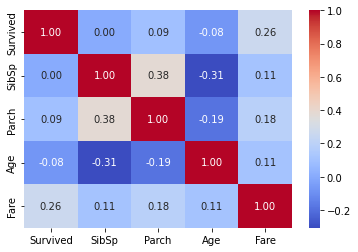

In [19]:
sns.heatmap(df[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

A maior correlação com sobrevivência é a taxa paga "Fare" que reflete o observado anteriormente na questão de membros de qual classe sobreviveram mais.

#### SibSP

In [20]:
df[['SibSp', 'Survived']].groupby('SibSp').mean().sort_values(by = 'Survived', ascending = False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
4,0.166667
3,0.153846
5,0.000000


Text(0.5, 1.0, 'Relação de sobrevivência e SibSp')

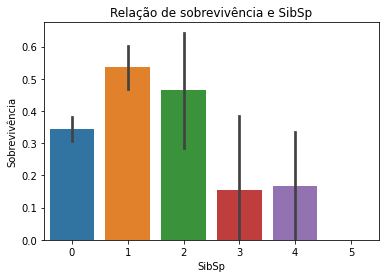

In [21]:
sns.barplot(x = 'SibSp', y ='Survived', data = df)
plt.ylabel('Sobrevivência')
plt.title('Relação de sobrevivência e SibSp')

#### Parch

In [22]:
df['Parch'].value_counts(dropna = False)

0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [23]:
df[['Parch', 'Survived']].groupby('Parch', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Text(0.5, 1.0, 'Relação de sobrevivência e Parch')

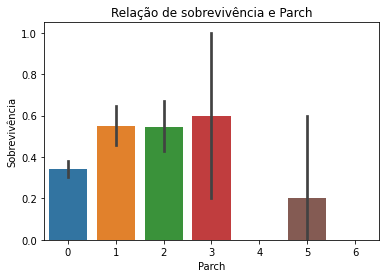

In [24]:
sns.barplot(x = 'Parch', y ='Survived', data = df)
plt.ylabel('Sobrevivência')
plt.title('Relação de sobrevivência e Parch')

#### Age

Text(0.5, 1.0, 'Distribuição de idade e relação com sobrevivência')

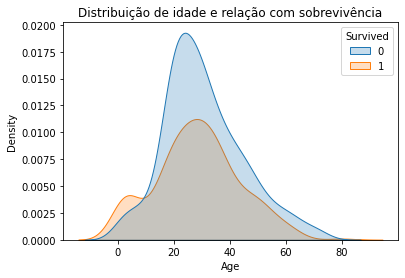

In [25]:
sns.kdeplot(x = 'Age', hue = 'Survived', data = df, shade = True)
plt.title('Distribuição de idade e relação com sobrevivência')

#### Fare

Text(0.5, 1.0, 'Distribuição por preço da passagem')

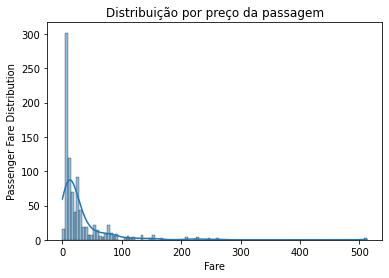

In [26]:
sns.histplot(df['Fare'], kde = True)
plt.ylabel('Passenger Fare Distribution')
plt.title('Distribuição por preço da passagem')

In [27]:
print(df['Fare'].skew())

5.058014586919519


Tem uma distorção forte para a esquerda na variável Fare, o que tem ser corrigido para melhorar o desempenho dos modelos.

# Manipulação e pré-processamento dos dados

Uma parcela do dados, as variáveis categóricas, já foram manipuladas previamente, agora tem-se que otimizar as numéricas e propor possíveis "Feature Engineering"

### Corrigir NaN de Age

<AxesSubplot:>

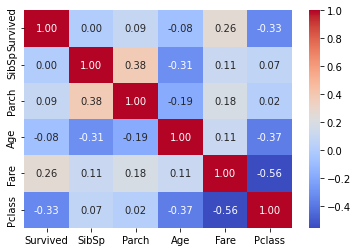

In [28]:
sns.heatmap(df[['Survived', 'SibSp', 'Parch', 'Age', 'Fare', 'Pclass']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

Correlação negativa forte com SibSP e Pclass e correlação mais fraca com Parch. Checar para substituir a idade com a média dos valores de entradas que tenham SibSp, Parch e Pclass iguais (Possível irmãos viajando com família)

In [29]:
age_nan_indices = list(df[df['Age'].isnull()].index)
age_median = list()
for index in age_nan_indices:
    age_median.append(df['Age'][(df['SibSp'] == df.iloc[index]['SibSp']) 
                                 & (df['Parch'] == df.iloc[index]['Parch'])
                                 & (df['Pclass'] == df.iloc[index]["Pclass"])].median())
print(age_median)

[26.0, 31.0, 26.0, 26.0, 26.0, 26.0, 36.0, 26.0, 26.0, 26.0, 26.0, 25.0, 26.0, 26.0, 38.5, 38.5, 19.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 25.0, 26.0, 26.0, 19.0, 24.0, 26.0, 26.0, 37.5, 38.5, 3.0, 31.0, 38.5, 25.0, 26.0, 26.0, 25.0, 26.0, 3.0, 26.0, 25.0, 25.0, 26.0, 38.5, 26.0, 26.0, 38.5, 26.0, 31.0, 38.5, 38.5, 38.5, 26.0, 26.0, 31.0, 26.0, 38.5, 26.0, 36.0, 26.0, 25.0, 38.5, 26.0, 26.0, 26.0, 25.0, 26.0, 26.0, 36.0, 26.0, 26.0, 3.0, 26.0, 26.0, 31.0, 26.0, 26.0, 26.0, 26.0, 25.0, 26.0, 25.0, 26.0, 36.0, 26.0, 26.0, 31.0, 26.0, 26.0, 38.5, 31.0, 3.0, 25.0, 26.0, 26.0, 26.0, 38.5, 26.0, 26.0, 26.0, 26.0, 38.5, 26.0, 24.0, 26.0, 31.0, 26.0, 38.5, 26.0, 26.0, 26.0, 26.0, 26.0, 25.0, 26.0, 26.0, 24.0, 31.0, 26.0, 26.0, 38.5, 26.0, 25.0, 26.0, 26.0, 38.5, 25.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 36.0, 31.0, 26.0, 26.0, 26.0, 19.0, 38.5, 26.0, 26.0, 31.0, 26.0, 26.0, 38.5, 26.0, 38.5, 25.0, 26.0, 26.0, 26.0, 13.5, 26.0, 38.5, 38.5, 26.0, 26.0, 26.0, 26.0, 26.0, 38.5, 36.0, 26.0, 2

In [30]:
age_median = list()
for index in age_nan_indices:
    median_age = df['Age'].median()
    predict_age = df['Age'][(df['SibSp'] == df.iloc[index]['SibSp']) 
                                 & (df['Parch'] == df.iloc[index]['Parch'])
                                 & (df['Pclass'] == df.iloc[index]["Pclass"])].median()
    if np.isnan(predict_age):
        df.at[index, 'Age'] = median_age
    else:
        df.at[index, 'Age'] = predict_age
        age_median.append(predict_age)
        
print(age_median)
print(median_age)
df['Age'].isnull().sum()

[26.0, 31.0, 26.0, 26.0, 26.0, 26.0, 36.0, 26.0, 26.0, 26.0, 26.0, 25.0, 26.0, 26.0, 38.5, 38.5, 19.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 25.0, 26.0, 26.0, 19.0, 24.0, 26.0, 26.0, 37.5, 38.5, 3.0, 31.0, 38.5, 25.0, 26.0, 26.0, 25.0, 26.0, 3.0, 26.0, 25.0, 25.0, 26.0, 38.5, 26.0, 26.0, 38.5, 26.0, 31.0, 38.5, 38.5, 38.5, 26.0, 26.0, 31.0, 26.0, 38.5, 26.0, 36.0, 26.0, 25.0, 38.5, 26.0, 26.0, 26.0, 25.0, 26.0, 26.0, 36.0, 26.0, 26.0, 3.0, 26.0, 26.0, 31.0, 26.0, 26.0, 26.0, 26.0, 25.0, 26.0, 25.0, 26.0, 36.0, 26.0, 26.0, 31.0, 26.0, 26.0, 38.5, 31.0, 3.0, 25.0, 26.0, 26.0, 26.0, 38.5, 26.0, 26.0, 26.0, 26.0, 38.5, 26.0, 24.0, 26.0, 31.0, 26.0, 38.5, 26.0, 26.0, 26.0, 26.0, 26.0, 25.0, 26.0, 26.0, 24.0, 31.0, 26.0, 26.0, 38.5, 26.0, 25.0, 26.0, 26.0, 38.5, 25.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 36.0, 31.0, 26.0, 26.0, 26.0, 19.0, 38.5, 26.0, 26.0, 31.0, 26.0, 26.0, 38.5, 26.0, 38.5, 25.0, 26.0, 26.0, 26.0, 13.5, 26.0, 38.5, 38.5, 26.0, 26.0, 26.0, 26.0, 26.0, 38.5, 36.0, 26.0, 2

0

In [31]:
age_nan_indices = list(df_test[df_test['Age'].isnull()].index)

for index in age_nan_indices:
    median_age = df_test['Age'].median()
    predict_age = df_test['Age'][(df_test['SibSp'] == df_test.iloc[index]['SibSp']) 
                                 & (df_test['Parch'] == df_test.iloc[index]['Parch'])
                                 & (df_test['Pclass'] == df_test.iloc[index]["Pclass"])].median()
    if np.isnan(predict_age):
        df_test.at[index, 'Age'] = median_age
    else:
        df_test.at[index, 'Age'] = predict_age
        
df_test['Age'].isnull().sum()

C:\Users\thari\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\thari\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0

### Fare

Reduzir o Skewness dele. **Estudar melhor as técnicas para reduzir skewness de direita e esquerda**.

Text(0.5, 1.0, 'Distribuição fare')

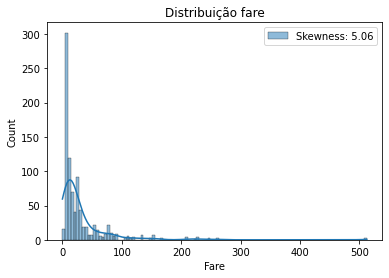

In [32]:
sns.histplot(df['Fare'],kde = True, label = 'Skewness: %.2f'%(df['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Distribuição fare')

[Text(0.5, 1.0, 'Skewness Cubo =  1.23')]

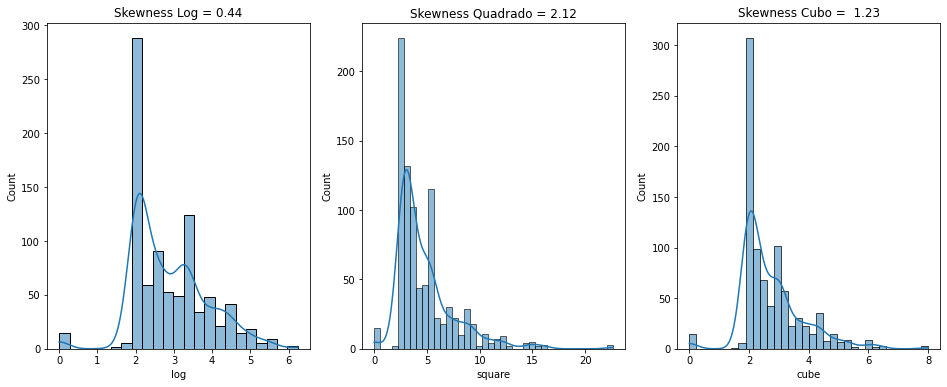

In [33]:
fare_skew = pd.DataFrame()
fare_skew['log'] = df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)
fare_skew['square'] = df['Fare'].map(lambda x: x**(1/2))
fare_skew['cube'] = df['Fare'].map(lambda x: x**(1/3))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,6))

sns.histplot(fare_skew['log'],kde = True, ax=ax1)
ax1.set(title = 'Skewness Log = %.2f'%(fare_skew['log'].skew()))

sns.histplot(fare_skew['square'],kde = True, ax=ax2)
ax2.set(title = 'Skewness Quadrado = %.2f'%(fare_skew['square'].skew()))

sns.histplot(fare_skew['cube'],kde = True, ax=ax3)
ax3.set(title = 'Skewness Cubo =  %.2f'%(fare_skew['cube'].skew()))

In [34]:
df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

df_test['Fare'] = df_test['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

Das 3 técnicas utilizadas, Log, raiz quadrada e raiz cúbica, o Log mostrou-se melhor. Não está apresentado no notebook, mas também foram testados elevar os valores ao quadrado e cubo, porém piorou fortemente a distorção.

# Feature Engineering

- Title
- Flag para família (Sozinho ou com que tamanho de família)
- Converter Fare para Fareband
- Converter Age em Ageband

### Title

In [35]:
df['Name'].head(20)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [36]:
df['Title'] = [name.split(',')[1].split('.')[0].strip() for name in df['Name']]
df[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [37]:
df['Title'].value_counts()

Mr              513
Miss            177
Mrs             125
Master           39
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

Existem vários títulos que são redudantes (Mlle e Ms para Miss) e outros que estão em pequenas quantidades e são "exóticos" como Capt, Countess, Col. Logo, tem que ajustar as as redundâncias e converter os exótico para uma nova classe de "Rare".
Mlle = Mademoiselle (Francês de Miss);
Ms = Miss;
Mme = Madame;

<AxesSubplot:xlabel='Title', ylabel='count'>

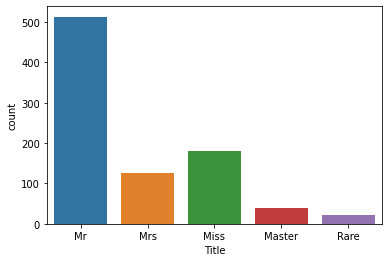

In [38]:
df['Title'] = df['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Jonkheer', 'Don', 'Capt', 'the Countess','Sir', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

sns.countplot(data = df, x = 'Title')



In [39]:
df[['Title', 'Survived']].groupby(['Title'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.711111
0,Master,0.589744
4,Rare,0.347826
2,Mr,0.157895


<AxesSubplot:xlabel='Title', ylabel='count'>

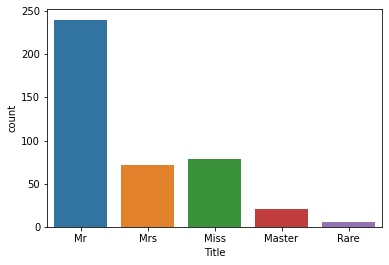

In [40]:
df_test['Title'] = [name.split(',')[1].split('.')[0].strip() for name in df_test['Name']]
df_test['Title'] = df_test['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Jonkheer', 'Don', 'Capt', 'the Countess','Sir', 'Dona'], 'Rare')
df_test['Title'] = df_test['Title'].replace(['Mlle', 'Ms'], 'Miss')
df_test['Title'] = df_test['Title'].replace('Mme', 'Mrs')

sns.countplot(data = df_test, x = 'Title')


In [41]:
df = pd.get_dummies(df, columns = ['Title'])
df_test = pd.get_dummies(df_test, columns = ['Title'])
df = df.drop(['Name'], axis = 1)
df_test = df_test.drop(['Name'], axis = 1)

### IsAlone e FamilySize

Criar a feature Is Alone e a feature FamilySize e implementar as duas no modelo.

In [42]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
df[['FamilySize', 'Survived']].groupby('FamilySize', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000


In [43]:
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

df_test['IsAlone'] = 0
df_test.loc[df_test['FamilySize'] == 1, 'IsAlone'] = 1

df[['IsAlone', 'Survived']].groupby('IsAlone', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,IsAlone,Survived
0,0,0.514535
1,1,0.303538


In [44]:
df = df.drop(['Parch', 'SibSp'], axis = 1)
df_test = df_test.drop(['Parch', 'SibSp'], axis = 1)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      881 non-null    int64  
 1   Pclass        881 non-null    int64  
 2   Sex           881 non-null    int64  
 3   Age           881 non-null    float64
 4   Fare          881 non-null    float64
 5   Em_C          881 non-null    uint8  
 6   Em_Q          881 non-null    uint8  
 7   Em_S          881 non-null    uint8  
 8   Title_Master  881 non-null    uint8  
 9   Title_Miss    881 non-null    uint8  
 10  Title_Mr      881 non-null    uint8  
 11  Title_Mrs     881 non-null    uint8  
 12  Title_Rare    881 non-null    uint8  
 13  FamilySize    881 non-null    int64  
 14  IsAlone       881 non-null    int64  
dtypes: float64(2), int64(5), uint8(8)
memory usage: 55.2 KB


In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   418 non-null    int64  
 1   Pclass        418 non-null    int64  
 2   Sex           418 non-null    int64  
 3   Age           418 non-null    float64
 4   Fare          418 non-null    float64
 5   Em_C          418 non-null    uint8  
 6   Em_Q          418 non-null    uint8  
 7   Em_S          418 non-null    uint8  
 8   Title_Master  418 non-null    uint8  
 9   Title_Miss    418 non-null    uint8  
 10  Title_Mr      418 non-null    uint8  
 11  Title_Mrs     418 non-null    uint8  
 12  Title_Rare    418 non-null    uint8  
 13  FamilySize    418 non-null    int64  
 14  IsAlone       418 non-null    int64  
dtypes: float64(2), int64(5), uint8(8)
memory usage: 26.2 KB


### Fare

In [47]:
df['FareBand'] = pd.cut(df['Fare'], 5)
df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by = 'FareBand')

,FareBand,Survived
0,"(-0.00624, 1.248]",0.066667
1,"(1.248, 2.496]",0.225627
2,"(2.496, 3.743]",0.431884
3,"(3.743, 4.991]",0.669118
4,"(4.991, 6.239]",0.692308


In [48]:
df.loc[df['Fare'] <= 1.248, 'Fare'] = 0
df.loc[(df['Fare'] > 1.248) & (df['Fare'] <= 2.496), 'Fare'] = 1
df.loc[(df['Fare'] > 2.496) & (df['Fare'] <= 3.743), 'Fare'] = 2
df.loc[(df['Fare'] > 3.743) & (df['Fare'] <= 4.991), 'Fare'] = 3
df.loc[df['Fare'] > 4.991, 'Fare'] = 4

In [49]:
df['Fare'] = df['Fare'].astype('int')
df = df.drop('FareBand', axis = 1)

In [50]:
df_test.loc[df_test['Fare'] <= 1.248, 'Fare'] = 0
df_test.loc[(df_test['Fare'] > 1.248) & (df_test['Fare'] <= 2.496), 'Fare'] = 1
df_test.loc[(df_test['Fare'] > 2.496) & (df_test['Fare'] <= 3.743), 'Fare'] = 2
df_test.loc[(df_test['Fare'] > 3.743) & (df_test['Fare'] <= 4.991), 'Fare'] = 3
df_test.loc[df_test['Fare'] > 4.991, 'Fare'] = 4
df_test['Fare'] = df['Fare'].astype('int')

### Age

In [51]:
df['AgeBand'] = pd.cut(df['Age'], 5)
df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by = 'AgeBand')

,AgeBand,Survived
0,"(0.34, 16.336]",0.518868
1,"(16.336, 32.252]",0.343816
2,"(32.252, 48.168]",0.412844
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [52]:
df.loc[df['Age'] <= 16.336, 'Age'] = 0
df.loc[(df['Age'] > 16.336) & (df['Age'] <=  32.252), 'Age'] = 1
df.loc[(df['Age'] >  32.252) & (df['Age'] <= 48.168), 'Age'] = 2
df.loc[(df['Age'] > 48.168) & (df['Age'] <= 64.084), 'Age'] = 3
df.loc[df['Age'] > 64.084, 'Age'] = 4
df['Age'] = df['Age'].astype('int')
df = df.drop('AgeBand', axis = 1)

In [53]:
df_test.loc[df_test['Age'] <= 16.336, 'Age'] = 0
df_test.loc[(df_test['Age'] > 16.336) & (df_test['Age'] <=  32.252), 'Age'] = 1
df_test.loc[(df_test['Age'] >  32.252) & (df_test['Age'] <= 48.168), 'Age'] = 2
df_test.loc[(df_test['Age'] > 48.168) & (df_test['Age'] <= 64.084), 'Age'] = 3
df_test.loc[df_test['Age'] > 64.084, 'Age'] = 4
df_test['Age'] = df_test['Age'].astype('int')


# Checar os dados antes dos FIT

In [54]:
df.head(10)

,Survived,Pclass,Sex,Age,Fare,Em_C,Em_Q,Em_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamilySize,IsAlone
0,0,3,1,1,1,0,0,1,0,0,1,0,0,2,0
1,1,1,0,2,3,1,0,0,0,0,0,1,0,2,0
2,1,3,0,1,1,0,0,1,0,1,0,0,0,1,1
3,1,1,0,2,3,0,0,1,0,0,0,1,0,2,0
4,0,3,1,2,1,0,0,1,0,0,1,0,0,1,1
5,0,3,1,1,1,0,1,0,0,0,1,0,0,1,1
6,0,1,1,3,3,0,0,1,0,0,1,0,0,1,1
7,0,3,1,0,2,0,0,1,1,0,0,0,0,5,0
8,1,3,0,1,1,0,0,1,0,0,0,1,0,3,0
9,1,2,0,0,2,1,0,0,0,0,0,1,0,2,0


In [55]:
df_test.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Em_C,Em_Q,Em_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamilySize,IsAlone
0,892,3,1,2,1,0,1,0,0,0,1,0,0,1,1
1,893,3,0,2,3,0,0,1,0,0,0,1,0,2,0
2,894,2,1,3,1,0,1,0,0,0,1,0,0,1,1
3,895,3,1,1,3,0,0,1,0,0,1,0,0,1,1
4,896,3,0,1,1,0,0,1,0,0,0,1,0,3,0
5,897,3,1,0,1,0,0,1,0,0,1,0,0,1,1
6,898,3,0,1,3,0,1,0,0,1,0,0,0,1,1
7,899,2,1,1,2,0,0,1,0,0,1,0,0,3,0
8,900,3,0,1,1,1,0,0,0,0,0,1,0,1,1
9,901,3,1,1,2,0,0,1,0,0,1,0,0,3,0


# Modelos

   - Logistic regression
   - Support vector machines
   - K-nearest neighbours
   - Gaussian naive bayes
   - Perceptron
   - Linear SVC
   - Stochastic gradient descent
   - Decision tree
   - Random forest
   - CatBoost


In [56]:
X_train = df.drop('Survived', axis = 1)
Y_train = df['Survived']
X_test = df_test.drop('PassengerId', axis = 1).copy()

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Pclass        881 non-null    int64
 1   Sex           881 non-null    int64
 2   Age           881 non-null    int32
 3   Fare          881 non-null    int32
 4   Em_C          881 non-null    uint8
 5   Em_Q          881 non-null    uint8
 6   Em_S          881 non-null    uint8
 7   Title_Master  881 non-null    uint8
 8   Title_Miss    881 non-null    uint8
 9   Title_Mr      881 non-null    uint8
 10  Title_Mrs     881 non-null    uint8
 11  Title_Rare    881 non-null    uint8
 12  FamilySize    881 non-null    int64
 13  IsAlone       881 non-null    int64
dtypes: int32(2), int64(4), uint8(8)
memory usage: 41.4 KB


In [57]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearSVC(dual=False)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('PRCP', Perceptron()))
models.append(('SGDC', SGDClassifier()))
models.append(('RFC',RandomForestClassifier(n_estimators = 100)))
models.append(('CatB', CatBoostClassifier(silent = True)))

# evaluate each model in turn
results = []
names = []
model_results = {}
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
	model_results[name] =  (cv_results.mean(), cv_results.std())
    
df_mdls = pd.DataFrame.from_dict(model_results)

LR: 0.820723 (0.037551)
LDA: 0.827554 (0.040384)
KNN: 0.812768 (0.039435)
CART: 0.797983 (0.028445)
NB: 0.785572 (0.054269)
SVM: 0.828664 (0.031067)
PRCP: 0.675281 (0.152701)
SGDC: 0.776468 (0.059101)
RFC: 0.807074 (0.035337)
CatB: 0.815015 (0.029847)


In [58]:
df_mdls = df_mdls.T.rename(columns={0: "Accuracy", 1: "Accuracy STDeviation"})
df_mdls

,Accuracy,Accuracy STDeviation
LR,0.820723,0.037551
LDA,0.827554,0.040384
KNN,0.812768,0.039435
CART,0.797983,0.028445
NB,0.785572,0.054269
SVM,0.828664,0.031067
PRCP,0.675281,0.152701
SGDC,0.776468,0.059101
RFC,0.807074,0.035337
CatB,0.815015,0.029847


In [59]:
df_mdls.sort_values(by = 'Accuracy', ascending = False)

,Accuracy,Accuracy STDeviation
SVM,0.828664,0.031067
LDA,0.827554,0.040384
LR,0.820723,0.037551
CatB,0.815015,0.029847
KNN,0.812768,0.039435
RFC,0.807074,0.035337
CART,0.797983,0.028445
NB,0.785572,0.054269
SGDC,0.776468,0.059101
PRCP,0.675281,0.152701


## Tunando hyperparâmetros

### SVM 

Seguindo um dos tutoriais sobre o titanic, o SVM mostrou desempenho bom, logo, vou seguir o tunning apresentado.

In [60]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True) 

grid.fit(X_train, Y_train) 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [61]:
print("Best parameters: ", grid.best_params_) 
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator:  SVC(C=100, gamma=0.01)


In [62]:
svc_t = SVC(C = 100, gamma = 0.01, kernel = 'rbf')
svc_t.fit(X_train, Y_train)
cross_val_score(svc_t, X_train, Y_train, scoring = 'accuracy', cv = 10).mean()

0.8297242083758938

# Prevendo os dados e preparando para submeter no Kaggle

In [63]:
Y_pred = svc_t.predict(X_test)

print(Y_pred, '\n\n\n',  len(Y_pred))

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1] 


 418


In [64]:
param_grid = {'n_components': [10, 15, 20, 30], 'learning_decay': [.5, .7, .9]}
Lestimator.get_params().keys()

NameError: name 'Lestimator' is not defined

In [ ]:
sub = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': Y_pred})
print(sub.head(), '\n\n\n', sub.shape)

In [ ]:
sub.to_csv('svm_titanic.csv', index = False)

In [ ]:
print("Best parameters: ", grid.best_params_) 
print("Best estimator: ", grid.best_estimator_)

In [ ]:
df.head(20)